In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
presentation_analysis = pd.read_csv('transcripts/LLM_outputs_presentation.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')
emotions_analysts = pd.read_csv('goemotions/analysts_summary_final.csv', delimiter='|')

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

In [3]:
presentation_analysis.rename(columns={'language_accessibility': 'language_accessibility_presentation'}, inplace=True)
qna_analysis.rename(columns={'language_accessibility': 'language_accessibility_qna'}, inplace=True)

qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)
emotions_analysts = emotions_analysts[["call_ID"] + emotions]
emotions_analysts.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(presentation_analysis, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

for emotion in emotions:
    llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
    llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)
    scaler = MinMaxScaler()
    llm_output[emotion] = scaler.fit_transform(llm_output[[emotion]])

llm_output = pd.merge(llm_output, emotions_analysts, on='call_ID', how='left')

# rename emotions_x to emotions and emotions_y to emotions_analysts
for emotion in emotions:
    llm_output.rename(columns={f'{emotion}_x': f'{emotion}', f'{emotion}_y': f'{emotion}_analysts'}, inplace=True)

llm_output.head()

# export the final dataset
llm_output.to_csv('transcripts/LLM_outputs_final.csv', index=False)

In [4]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [5]:
def create_colored_chart(model, type):

    # Filter significant features
    significant_features = model.pvalues[model.pvalues < 0.05].index
    importances = model.params[significant_features]  # Only significant features
    importances = importances[1:]

    # Sort importances by their absolute value, and select the top 10
    top_12_importances = importances.abs().sort_values(ascending=False).head(10)
    importances = importances[top_12_importances.index]
    importances = importances.sort_values()  # Sort the values for better visualization

    # Define emotion types (assuming the feature names match these emotion labels)
    emotion_types = {
        'relief': 'positive',
        'remorse': 'negative',
        'nervousness': 'negative',
        'desire': 'positive',
        'fear': 'strong_negative',
        'excitement': 'positive',
        'confusion': 'negative',
        'pride': 'positive',
        'annoyance': 'negative',
        'gratitude': 'positive',
        'anger': 'strong_negative',
        'optimism': 'positive',
        'sadness': 'negative', 
        'approval': 'positive',
        'caring': 'positive',
        'disappointment': 'negative',
        'curiosity': 'positive',
        'surprise': 'positive',
        'admiration': 'positive',
        'embarrassment': 'negative',
        'realization': 'positive',
        'disapproval': 'negative',
        'joy': 'positive',
        'relief_analysts': 'positive',
        'remorse_analysts': 'negative',
        'nervousness_analysts': 'negative',
        'desire_analysts': 'positive',
        'fear_analysts': 'strong_negative',
        'excitement_analysts': 'positive',
        'confusion_analysts': 'negative',
        'pride_analysts': 'positive',
        'annoyance_analysts': 'negative',
        'gratitude_analysts': 'positive',
        'anger_analysts': 'strong_negative',
        'optimism_analysts': 'positive',
        'sadness_analysts': 'negative',
        'approval_analysts': 'positive',
        'caring_analysts': 'positive',
        'disappointment_analysts': 'negative',
        'curiosity_analysts': 'positive',
        'surprise_analysts': 'positive',
        'admiration_analysts': 'positive',
        'embarrassment_analysts': 'negative',
        'realization_analysts': 'positive',
        'disapproval_analysts': 'negative',
        'joy_analysts': 'positive'
    }

    # Map colors to each emotion type
    color_mapping = {
        'positive': 'green',
        'strong_negative': 'red',
        'negative': 'gray',
    }

    # Apply the color mapping to the top 12 significant features
    colors = []
    for feature in importances.index:
        if feature in supporting_features_1 or feature in supporting_features_2:
            colors.append('blue')
        elif feature in presentation_labels or feature in qna_labels:
            colors.append('orange')
        elif feature in emotion_types:
            colors.append(color_mapping[emotion_types[feature]])
        else:
            colors.append('purple')  # Default for unknown features

    # Create a horizontal bar plot for the top 12 significant features
    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')

    # Add labels and title
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Significant Features and their Impact')

    if type == 'Management Emotions' or type == 'Analyst Emotions' or type == 'All Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'All Earnings call':
        # Create a custom legend
        handles = [
            #plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                #'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & Presentation Labels' or type == 'Financial Data & Q&A Labels' or type == 'Financial Data 1&2 & LLM Labels':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Emotions' or type == 'Financial Data & Management Emotions' or type == 'Financial Data & Analyst Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Earnings call':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'New Metrics':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='purple'),
        ]
        labels = [
                'Financial Data', 
                'New Metrics',
                ]
        # Add the legend
        plt.legend(handles, labels)

    # Show the plot
    return plt.show()


def create_significant_chart(model):

    # select significant features
    model.significance = model.pvalues[model.pvalues < 0.05].index

    # build a graph to show the importance of each feature
    importances = model.params[1:]
    importances = importances.sort_values()

    # Sort the importance values based on absolute values, not just positive or negative
    top_10_importances = importances.abs().sort_values(ascending=False).head(10)

    # reduce importances to only the top 10
    importances = importances[top_10_importances.index]
    importances = importances.sort_values()

    # color significant features 0/150/130 and others in grey
    colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')
    
    # add legend
    plt.legend(['Significant'])
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Features Impact on Recovery Rate')
    return plt.show()

In [6]:
'''BOND LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = llm_output[['RR']
                    + supporting_features_1
                    + supporting_features_2
                    + presentation_labels 
                    + qna_labels
                    #+ qna_mgmt
                    #+ qna_analysts
                    + emotions
                    + analyst_emotions
                    ]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

In [7]:
feature_sets = {'Financial Data 1': supporting_features_1, 
                'Financial Data 1&2': supporting_features_1 + supporting_features_2,
                ## Earnings call features
                'Presentation Labels': presentation_labels, 
                'Q&A Labels':qna_labels, 
                'Management Emotions': emotions, 
                'Analyst Emotions': analyst_emotions,
                'LLM Labels': presentation_labels + qna_labels,
                'All Emotions': emotions + analyst_emotions,
                'All Earnings call': presentation_labels + qna_labels + emotions + analyst_emotions,
                ## Earnings call features and financial data
                'Financial Data 1&2 & Presentation Labels': supporting_features_1 + supporting_features_2 + presentation_labels,
                'Financial Data 1&2 & Q&A Labels': supporting_features_1 + supporting_features_2 + qna_labels,
                'Financial Data 1&2 & Management Emotions': supporting_features_1 + supporting_features_2 + emotions,
                'Financial Data 1&2 & Analyst Emotions': supporting_features_1 + supporting_features_2 + analyst_emotions,
                'Financial Data 1&2 & LLM Labels': supporting_features_1 + supporting_features_2 + presentation_labels + qna_labels,
                'Financial Data 1&2 & All Emotions': supporting_features_1 + supporting_features_2 + emotions + analyst_emotions,
                'Financial Data 1&2 & All Earnings call': supporting_features_1 + supporting_features_2 + presentation_labels + qna_labels + emotions + analyst_emotions
                }

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     87.95
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.69e-220
Time:                        12:11:16   Log-Likelihood:                -4460.9
No. Observations:                1075   AIC:                             8968.
Df Residuals:                    1052   BIC:                             9082.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

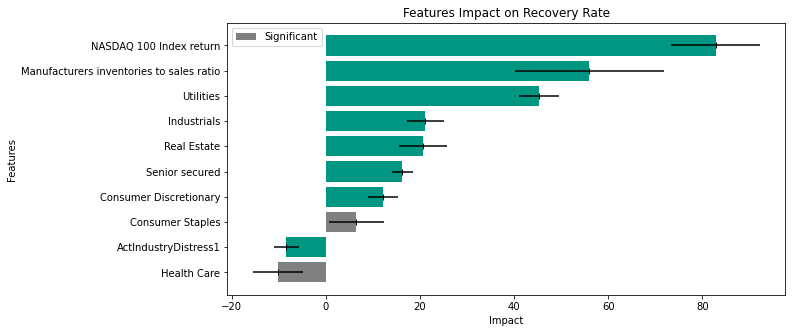

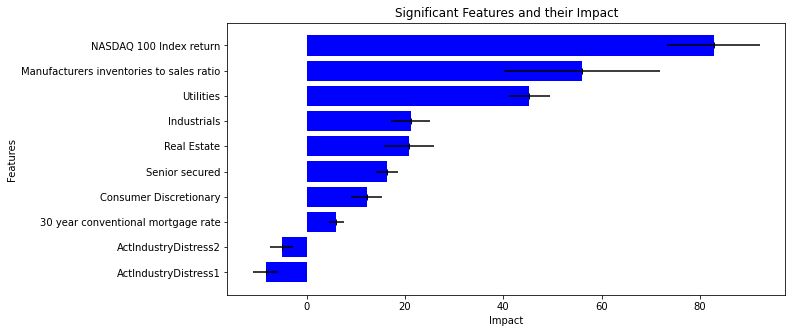

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     84.11
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          3.12e-235
Time:                        12:11:16   Log-Likelihood:                -4416.0
No. Observations:                1075   AIC:                             8886.
Df Residuals:                    1048   BIC:                             9020.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

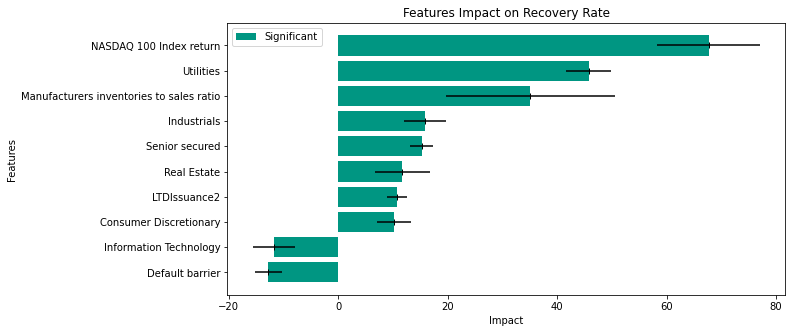

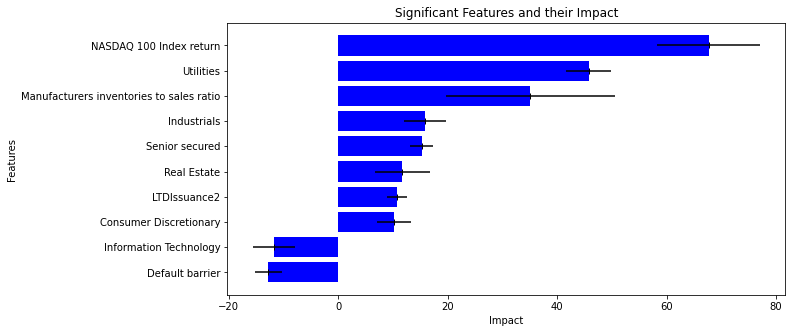

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     43.54
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           1.84e-99
Time:                        12:11:17   Log-Likelihood:                -4763.5
No. Observations:                1075   AIC:                             9559.
Df Residuals:                    1059   BIC:                             9639.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

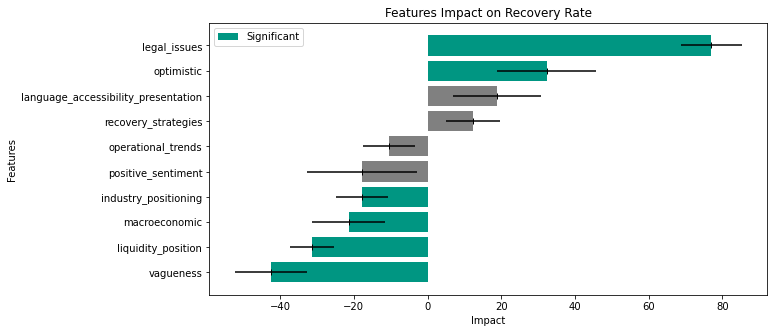

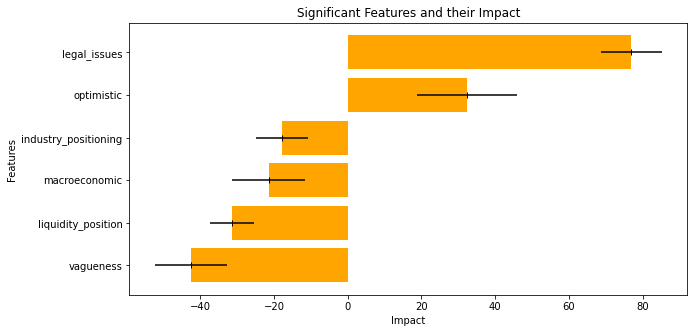

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     66.33
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.01e-79
Time:                        12:11:17   Log-Likelihood:                -4827.6
No. Observations:                1075   AIC:                             9671.
Df Residuals:                    1067   BIC:                             9711.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

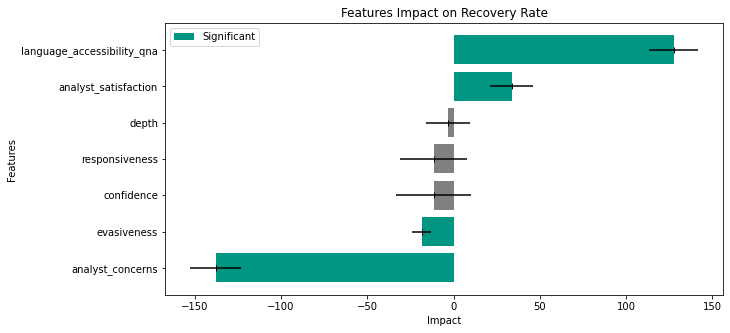

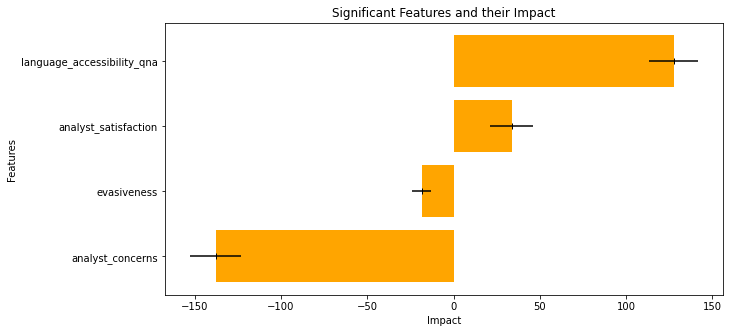

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     16.34
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           4.30e-53
Time:                        12:11:17   Log-Likelihood:                -4863.8
No. Observations:                1075   AIC:                             9774.
Df Residuals:                    1052   BIC:                             9888.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             21.5125      3.926      5.

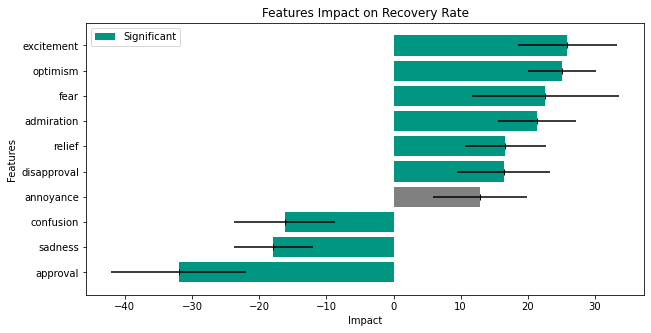

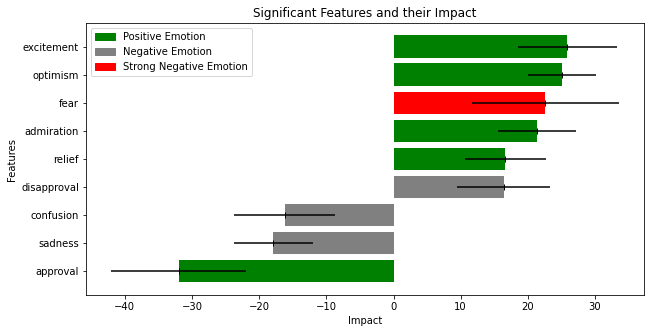

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     22.34
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           1.51e-72
Time:                        12:11:18   Log-Likelihood:                -4815.7
No. Observations:                1075   AIC:                             9677.
Df Residuals:                    1052   BIC:                             9792.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

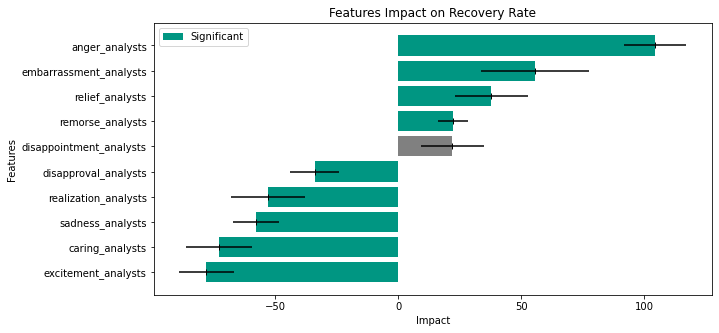

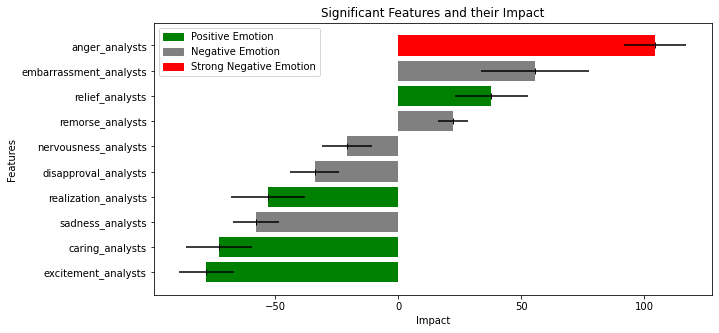

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     35.47
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          1.72e-110
Time:                        12:11:18   Log-Likelihood:                -4723.5
No. Observations:                1075   AIC:                             9493.
Df Residuals:                    1052   BIC:                             9608.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

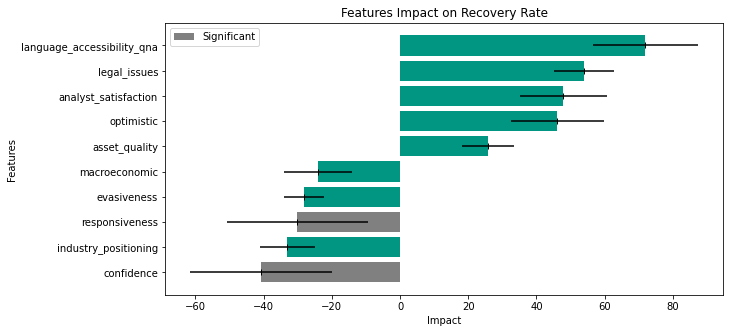

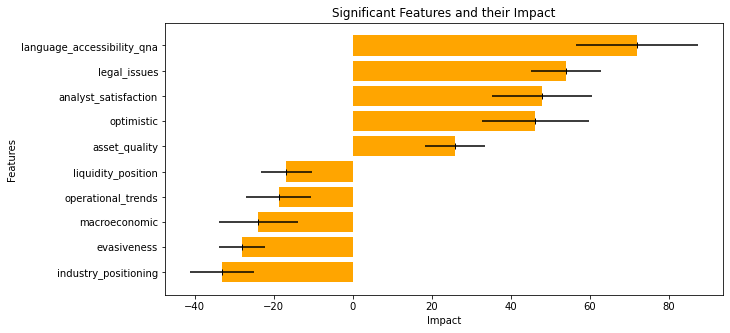

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     15.48
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           3.37e-85
Time:                        12:11:19   Log-Likelihood:                -4748.9
No. Observations:                1075   AIC:                             9588.
Df Residuals:                    1030   BIC:                             9812.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

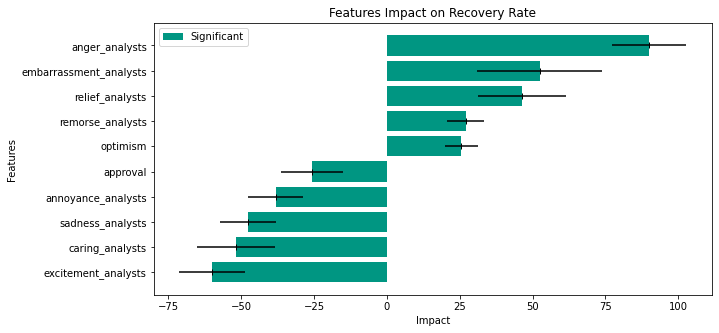

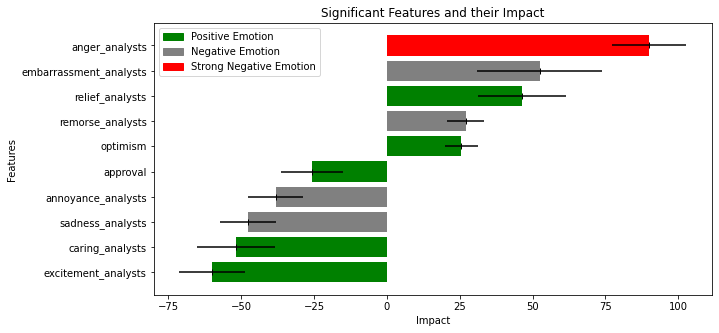

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     18.76
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          7.34e-133
Time:                        12:11:19   Log-Likelihood:                -4591.1
No. Observations:                1075   AIC:                             9316.
Df Residuals:                    1008   BIC:                             9650.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

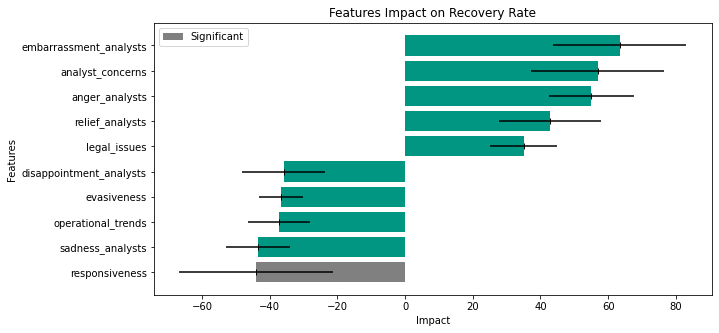

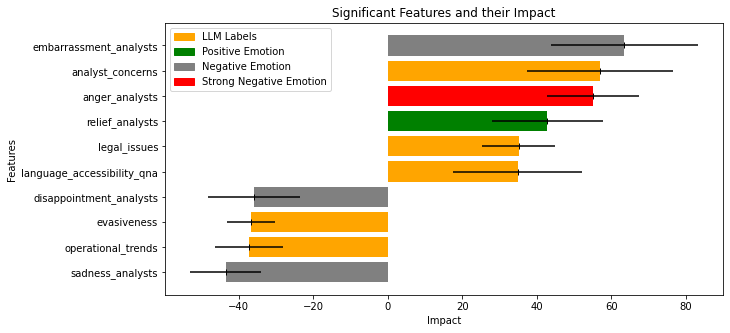

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     63.36
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          3.48e-250
Time:                        12:11:20   Log-Likelihood:                -4346.1
No. Observations:                1075   AIC:                             8776.
Df Residuals:                    1033   BIC:                             8985.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

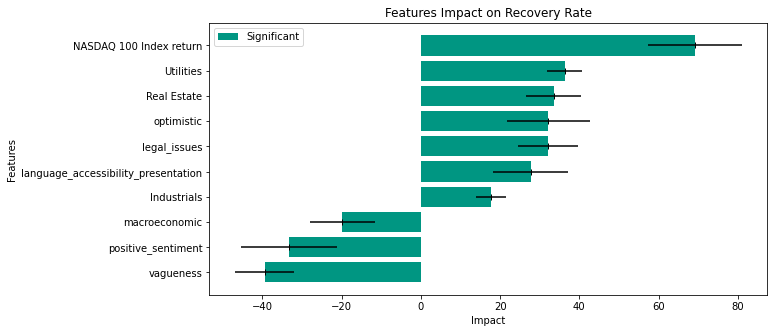

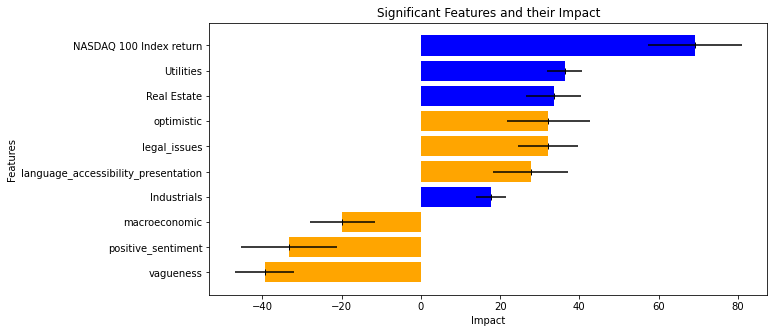

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     70.85
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          7.49e-240
Time:                        12:11:20   Log-Likelihood:                -4388.9
No. Observations:                1075   AIC:                             8846.
Df Residuals:                    1041   BIC:                             9015.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

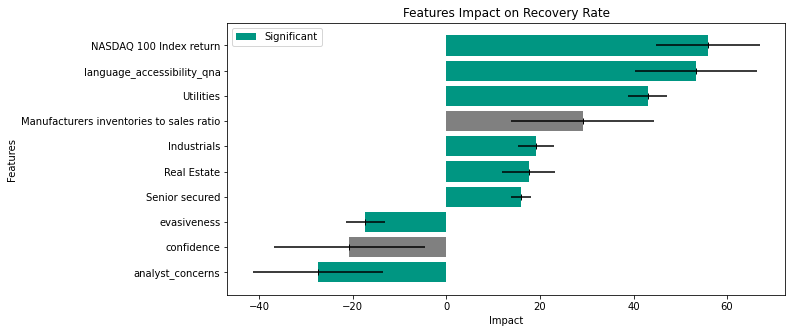

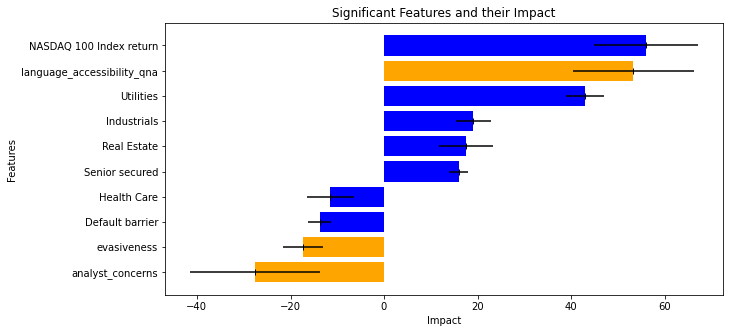

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     49.54
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.46e-231
Time:                        12:11:20   Log-Likelihood:                -4377.2
No. Observations:                1075   AIC:                             8852.
Df Residuals:                    1026   BIC:                             9096.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

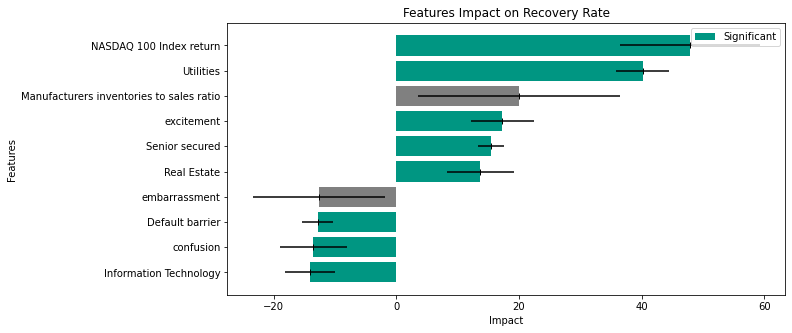

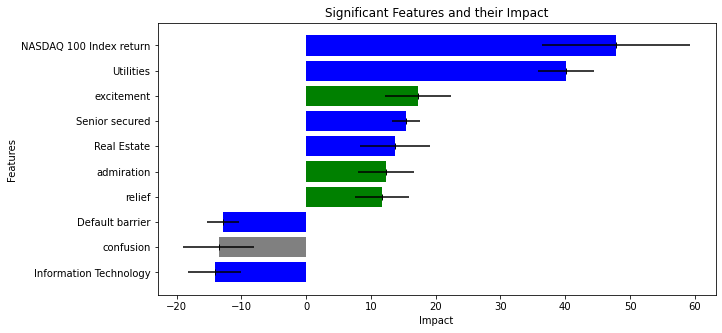

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     50.56
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          1.80e-234
Time:                        12:11:21   Log-Likelihood:                -4369.5
No. Observations:                1075   AIC:                             8837.
Df Residuals:                    1026   BIC:                             9081.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

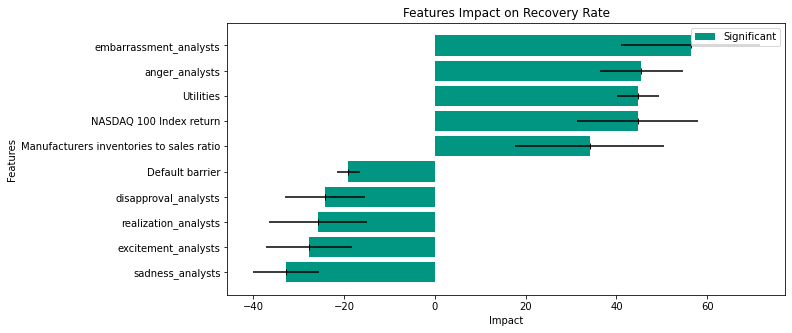

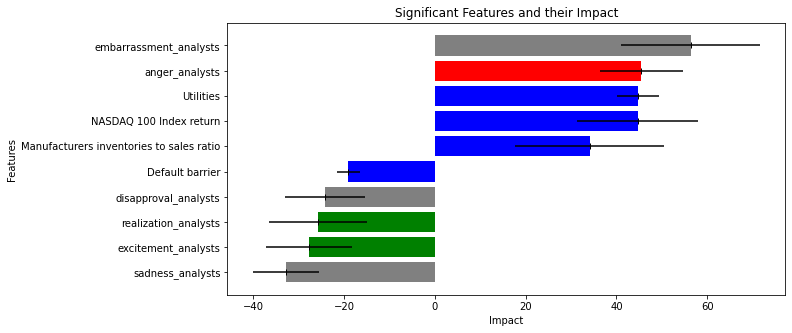

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     55.49
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          5.67e-249
Time:                        12:11:21   Log-Likelihood:                -4333.8
No. Observations:                1075   AIC:                             8766.
Df Residuals:                    1026   BIC:                             9010.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

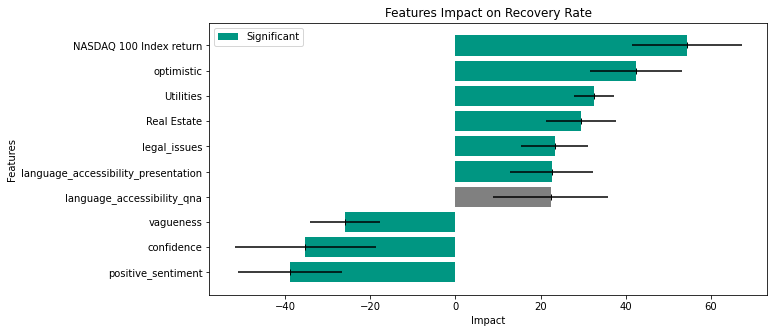

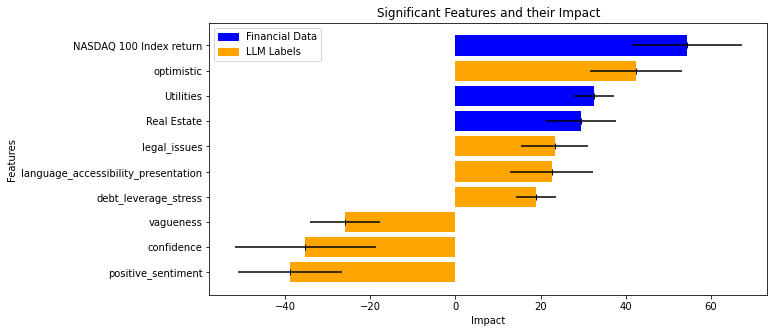

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     37.44
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          1.54e-231
Time:                        12:11:21   Log-Likelihood:                -4331.7
No. Observations:                1075   AIC:                             8805.
Df Residuals:                    1004   BIC:                             9159.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

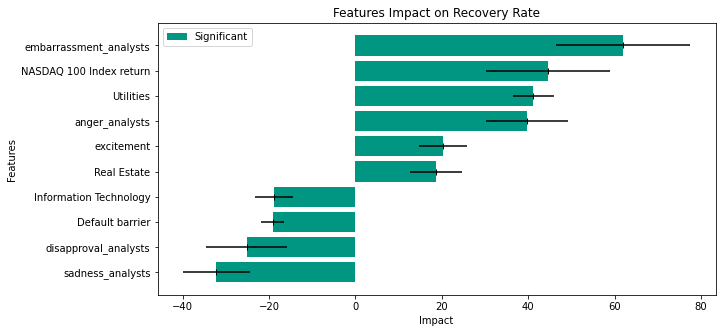

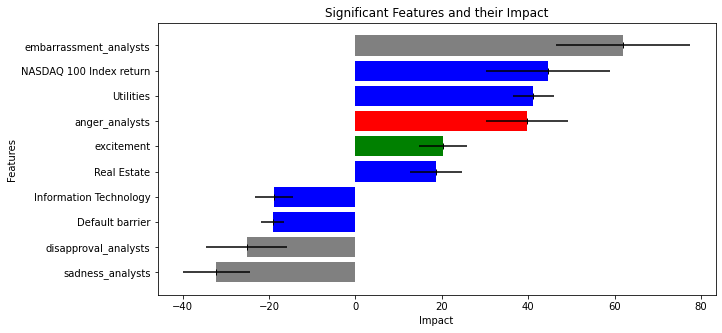

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     35.83
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          1.02e-253
Time:                        12:11:22   Log-Likelihood:                -4230.7
No. Observations:                1075   AIC:                             8647.
Df Residuals:                     982   BIC:                             9111.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

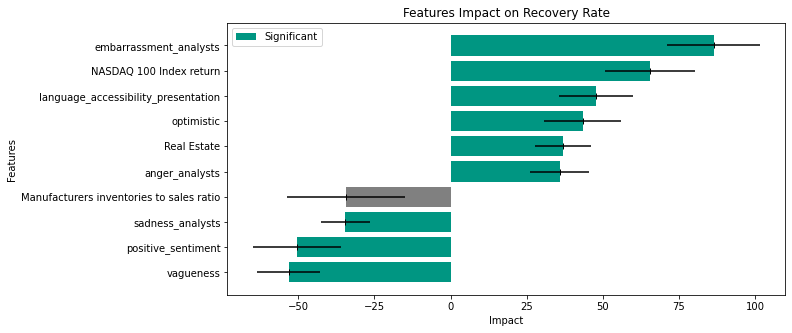

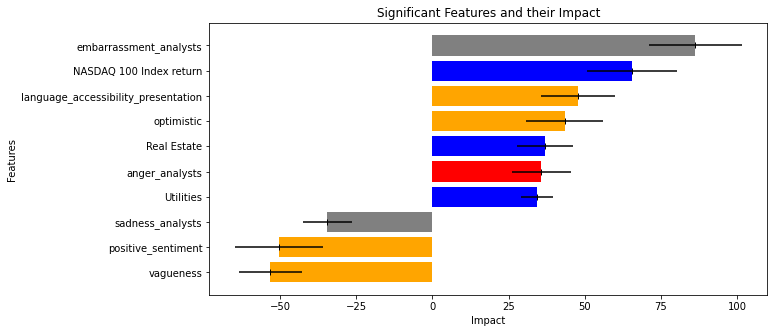

In [9]:
'''Dealer Recovery Rate Prediction'''
'''PRIMARY DEALER'''

for key in feature_sets:

    final_df = llm_output[['RR']+ feature_sets[key]]

    y = final_df['RR']
    X = final_df.drop(columns=['RR'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    if key == 'Financial Data 1&2 & All Earnings call':
        # export the final model
        model.save('models/aggregated_all_features_model.pkl')

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_significant_chart(model)
    create_colored_chart(model, key)